# skt kobert 
- batchsize=64, epoch=10, max_len=128
- 세션 종료 후 [13.전이학습 및 예측] 진행시,
  - [2.라이브러리 설치 및 불러오기]와 [4.토크나이징],[5.파라미터설정- 그래프 제외] 부분,  만들어놓은 class 들은 다 불러올것
  - [10.훈련] 부분은 절대 돌리지말기!!
- pre-trained 깃허브 : https://github.com/SKTBrain/KoBERT
- 사용법  : https://velog.io/@m0oon0/KoBERT-%EC%82%AC%EC%9A%A9%EB%B2%95, https://velog.io/@danbibibi/KoBERT-fine-tuning-Sentiment-Analysis

## 1. 데이터 불러오기
- 문장별 레이블링 처리된 데이터
- 로컬에서는 일부 데이터만 train해보기
- 이미 영어, 한자, 기타 불용어 제거된 데이터

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data=pd.read_excel('/content/drive/MyDrive/modeling_yy/train_data2.xlsx')
#test_=pd.read_excel('/content/drive/MyDrive/modeling_yy/test_data.xlsx')

In [ ]:
data.head()

,doc,label
0,손경식 회장 해외사업 공격적 확장 성장 가속화,1
1,신입사원 연차 생기고 공공기관 채용 역대 최대,1
2,2018년 채용연계형 인턴채용 문 열렸다,1
3,무술년 채용연계형 인턴채용 스타트,1
4,그냥 쉬었다 청년 30만명 역대 최고치,0


In [ ]:
data.groupby(['label'])['label'].count()

label
0    97614
1    96335
Name: label, dtype: int64

In [ ]:
data.shape

(193949, 2)

## 2. 라이브러리 설치 및 불러오기
- pytorch
- kobert


In [ ]:
#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
#==4.8.1

In [ ]:
#cuda 에러 해결 참고 : https://stackoverflow.com/questions/69968477/runtimeerror-cuda-error-no-kernel-image-is-available-for-execution-on-the-devi
#버전 에러발생으로 재설치
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

#kobert
from kobert.utils import get_tokenizer
#from kobert.pytorch_kobert import get_kobert_model
from kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

## CPU 사용시
#device = torch.device("cpu")

#GPU 사용, 학습시간 단축
device = torch.device("cuda:0")

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()


/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


## 3. 학습용 데이터 리스트 처리 후 train, test split
- skt kobert의 데이터형태

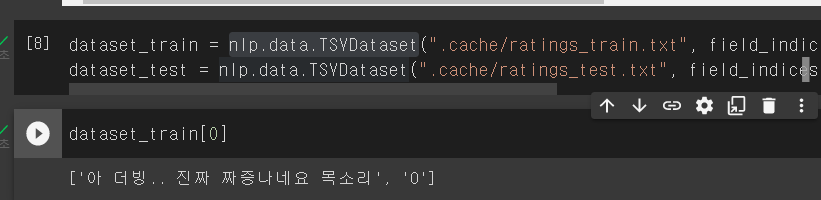

In [ ]:
all_data_list = []

for text, label in zip(data['doc'], data['label']):
  all_data = []
  all_data.append(text)
  all_data.append(label)
  all_data_list.append(all_data)

len(all_data_list)

193949

In [ ]:
#len(all_data_list[:30000])

In [ ]:
#data_for_train=all_data_list[:30000]

In [ ]:
all_data_list[:10]

[['손경식 회장 해외사업 공격적 확장 성장 가속화 ', 1],
 ['신입사원 연차 생기고 공공기관 채용 역대 최대', 1],
 ['2018년 채용연계형 인턴채용 문 열렸다', 1],
 ['무술년 채용연계형 인턴채용 스타트', 1],
 ['그냥 쉬었다 청년 30만명 역대 최고치', 0],
 ['청년 30만명 그냥 쉬었다 .최악 취업난에 니트족 증가', 0],
 ['하는 일 없이 그냥 쉬는 청년들 30만명 넘었다', 0],
 [' 최저임금 올라도 청년고용 영향 적어', 1],
 ['최악 취업난에 정부 대기업 채용 확대 초미관심', 1],
 ['원서 넣으면 뭐하나 실망실업자 48만 사상 최대 ', 0]]

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(all_data_list, test_size = 0.2, shuffle=True, random_state = 2023)


In [ ]:
data[['doc','label']]

,doc,label
0,손경식 회장 해외사업 공격적 확장 성장 가속화,1
1,신입사원 연차 생기고 공공기관 채용 역대 최대,1
2,2018년 채용연계형 인턴채용 문 열렸다,1
3,무술년 채용연계형 인턴채용 스타트,1
4,그냥 쉬었다 청년 30만명 역대 최고치,0
...,...,...
193944,디케이드 다음에 더블 다음에 오즈인데 더블은 조금밖에 안나오네요.,1
193945,인간이 문제지. 소는 뭔죄인가.,0
193946,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
193947,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


## 4. 토크나이징
- kobert 토크나이저와 pre-trained model 불러오기

In [ ]:
#kobert
from kobert.utils import get_tokenizer
tokenizer = get_tokenizer()

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()
#lower=False 한글이니까 상관 없을듯..?
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
vocab.idx_to_token[3]

'[SEP]'

In [ ]:
vocab.idx_to_token[1]

'[PAD]'

In [ ]:
vocab.idx_to_token[2]

'[CLS]'

In [ ]:
vocab.idx_to_token[0]

'[UNK]'

## 5. 파라미터 설정


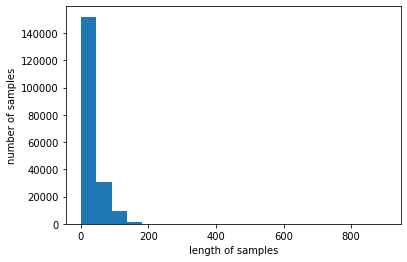

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(doc) for doc in data['doc']], bins = 20)
plt.xlabel('length of samples'), plt.ylabel('number of samples');

In [ ]:
max_len = 128 # max seqence length : 텍스트 데이터 최대 길이, 길이 200까지 대다수의 데이터가 분포
batch_size = 64 #128 대부분 문장길이
warmup_ratio = 0.1
num_epochs = 10 #훈련 반복 횟수
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [22]:
2425/64

37.890625

## 6. BERTDataset 만들기
- 4.의 토크나이저 적용해서 토큰화
- 정수 인코딩, padding 작업
-  BERTDataset 클래스 이용, TensorDataset으로 만들어주기 
- 0번째 index에 sentence,  1번째 index에 label

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [ ]:
data_train = BERTDataset(train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tok, max_len, True, False)

In [ ]:
train[0]

['애니메이션은 평타이상은 해주는것 같다.', 1]

In [ ]:
data_train.labels[0]

1

In [ ]:
data_train.sentences[0]

(array([   2, 3196, 7086, 4841, 7581, 7110, 7086,  517, 7857, 5398,  831,
         517,   54,    3,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(14, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,

## 7. data_load
- BERTDataset을 이용하여 dataset을 만들어준 후 분석용 train, test 데이터 loader 만들기

In [ ]:
# num_workers : how many subprocesses to use for data loading
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

## 8. 분류개수 설정 및 모델 설계
- 파인튜닝fine-tuning을 위한 분류기 정의
- bert 의 최종 결과값 : 마지막 은닉state의 첫 토큰, 마지막 은닉state 
- 이진 감성분석이므로 num_classes=2,

In [ ]:
class BERTClassifier(nn.Module):
  def __init__(self, bert, hidden_size=768, num_classes=2, dr_rate=None, params=None):
    super(BERTClassifier, self).__init__()
    self.bert = bert
    self.dr_rate = dr_rate

    self.classifier = nn.Linear(hidden_size , num_classes)
    if dr_rate:
      self.dropout = nn.Dropout(p=dr_rate)

  def gen_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i, v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    return attention_mask.float()

  def forward(self, token_ids, valid_length, segment_ids):
    attention_mask = self.gen_attention_mask(token_ids, valid_length)
    _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
    if self.dr_rate:
        out = self.dropout(pooler)
    else:
        out = pooler
    return self.classifier(out)

## 9. 옵티마이저, 스케줄 및 정확도 함수 설정

In [ ]:
# 설계한 bert 모델 불러오기 #gpu 연결됐는지 확인필수!!!
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

### optimizer, schedule (linear warmup and decay) 설정
- optimizer : AdamW-> L2 regularization과 weight decay 관점에서 SGD에 비해 일반화 능력이 떨어지는 문제점을 해결
- schedule : Learning rate schedule-> 미리 학습 일정을 정해두고, 그 일정에 따라 학습률을 조정하는 방법임. 학습이 진행됨에 따라 epoch 또는 iteration 간에 학습률을 조정하는 사전 정의된 프레임워크(스케쥴 개념 참고 : https://ai4nlp.tistory.com/8)
- loss fcn : 이진분류이므로 crossentropyloss 

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
# 최적화해야 할 parameter를 optimizer에게 알림
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

#옵티마이저, 손실함수 지정
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_loader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

### 정확도 함수 정의

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

## 10. 훈련 진행 및 epoch 별 정확도 측정
- num_epochs = 10 훈련 반복 횟수

In [ ]:
####################################################################################
#정확도 비교후 모델 업데이트 및 복사 
# deepcopy를 사용해야 모델이 온전히 복사가 됨. 일반 copy와는 다름.
###################################################################################

# checkpoint
from copy import deepcopy
best_acc = 0
best_acc_model = None 

#epoch 별 정확도 도출 

train_history=[]#train acc
test_history=[] #test acc
loss_history=[] # 전체 loss 
avg_loss_hisroty=[] #epoch별 평균 loss
test_loss_history=[]

for e in range(num_epochs):
    total_loss=0.0
    train_acc = 0.0
    test_acc = 0.0
    test_total_loss=0.0
    
    model.train() #훈련 선언
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_loader)): # len(train_loader)=2425
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
         
        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)

        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
            total_loss+=loss.data.cpu().numpy()

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    avg_loss=total_loss/len(train_loader) #epoch별 평균 loss값
    avg_loss_hisroty.append(avg_loss)
    train_history.append(train_acc / (batch_id+1))
    
    model.eval() #모델평가
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_loader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        test_acc += calc_accuracy(out, label)
        test_total_loss+=loss.data.cpu().numpy()
  
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))
    test_avg_loss=test_total_loss/len(test_loader)
    test_loss_history.append(test_avg_loss)


    
    if (test_acc / (batch_id+1)) > best_acc:
          best_acc = (test_acc / (batch_id+1))
          best_acc_model = deepcopy(model)  


    print("epoch {} test acc {} acc {}".format(e+1, test_acc / (batch_id+1), test_acc / (batch_id+1)))
 

<ipython-input-29-7868592a924f>:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_loader)):


  0%|          | 0/2425 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.715749204158783 train acc 0.453125
epoch 1 batch id 201 loss 0.6577898859977722 train acc 0.519356343283582
epoch 1 batch id 401 loss 0.6907530426979065 train acc 0.5915679551122195
epoch 1 batch id 601 loss 0.49157267808914185 train acc 0.6488404742096506
epoch 1 batch id 801 loss 0.36374831199645996 train acc 0.6815308988764045
epoch 1 batch id 1001 loss 0.3432456851005554 train acc 0.7051542207792207
epoch 1 batch id 1201 loss 0.38049784302711487 train acc 0.7220415278934221
epoch 1 batch id 1401 loss 0.35644859075546265 train acc 0.7344196109921485
epoch 1 batch id 1601 loss 0.3535093665122986 train acc 0.7438905371642723
epoch 1 batch id 1801 loss 0.47414055466651917 train acc 0.7516310383120489
epoch 1 batch id 2001 loss 0.3649432063102722 train acc 0.7588002873563219
epoch 1 batch id 2201 loss 0.4355073869228363 train acc 0.7651138686960473
epoch 1 batch id 2401 loss 0.341129869222641 train acc 0.7695491461890879
epoch 1 train acc 0.7701910578216047


<ipython-input-29-7868592a924f>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_loader)):


  0%|          | 0/607 [00:00<?, ?it/s]

epoch 1 test acc 0.8202996293245469
epoch 1 test acc 0.8202996293245469 acc 0.8202996293245469


  0%|          | 0/2425 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.4531646966934204 train acc 0.796875
epoch 2 batch id 201 loss 0.3424897789955139 train acc 0.826181592039801
epoch 2 batch id 401 loss 0.5466539263725281 train acc 0.8264884663341646
epoch 2 batch id 601 loss 0.3983834683895111 train acc 0.8278650166389351
epoch 2 batch id 801 loss 0.3506174385547638 train acc 0.8296855493133583
epoch 2 batch id 1001 loss 0.2946314513683319 train acc 0.8323707542457542
epoch 2 batch id 1201 loss 0.3054751455783844 train acc 0.8344088259783514
epoch 2 batch id 1401 loss 0.26191774010658264 train acc 0.8352739114917915
epoch 2 batch id 1601 loss 0.273233562707901 train acc 0.8372013585259213
epoch 2 batch id 1801 loss 0.3116268515586853 train acc 0.8385879372570794
epoch 2 batch id 2001 loss 0.2717352509498596 train acc 0.8405094327836082
epoch 2 batch id 2201 loss 0.2819337248802185 train acc 0.8429833030440709
epoch 2 batch id 2401 loss 0.19014374911785126 train acc 0.8444333090379009
epoch 2 train acc 0.8447708426714479


  0%|          | 0/607 [00:00<?, ?it/s]

epoch 2 test acc 0.825447899505766
epoch 2 test acc 0.825447899505766 acc 0.825447899505766


  0%|          | 0/2425 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.274985671043396 train acc 0.875
epoch 3 batch id 201 loss 0.24333816766738892 train acc 0.8648942786069652
epoch 3 batch id 401 loss 0.36206239461898804 train acc 0.8661938902743143
epoch 3 batch id 601 loss 0.2872219383716583 train acc 0.8685524126455907
epoch 3 batch id 801 loss 0.18542994558811188 train acc 0.8697721598002497
epoch 3 batch id 1001 loss 0.21301919221878052 train acc 0.8717064185814186
epoch 3 batch id 1201 loss 0.24573063850402832 train acc 0.8739201706910907
epoch 3 batch id 1401 loss 0.19386537373065948 train acc 0.8755130264097074
epoch 3 batch id 1601 loss 0.35561078786849976 train acc 0.8774008432229856
epoch 3 batch id 1801 loss 0.24926747381687164 train acc 0.8786871876735147
epoch 3 batch id 2001 loss 0.22604236006736755 train acc 0.8803566966516742
epoch 3 batch id 2201 loss 0.19566720724105835 train acc 0.882446899136756
epoch 3 batch id 2401 loss 0.1744285672903061 train acc 0.8832062161599333
epoch 3 train acc 0.8833611609143882


  0%|          | 0/607 [00:00<?, ?it/s]

epoch 3 test acc 0.8393739703459637
epoch 3 test acc 0.8393739703459637 acc 0.8393739703459637


  0%|          | 0/2425 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.2691895663738251 train acc 0.90625
epoch 4 batch id 201 loss 0.1454486846923828 train acc 0.9007307213930348
epoch 4 batch id 401 loss 0.2633809447288513 train acc 0.9015741895261845
epoch 4 batch id 601 loss 0.286298930644989 train acc 0.9024802412645591
epoch 4 batch id 801 loss 0.19270597398281097 train acc 0.9036555867665418
epoch 4 batch id 1001 loss 0.14027424156665802 train acc 0.9053758741258742
epoch 4 batch id 1201 loss 0.14314578473567963 train acc 0.9080193588676103
epoch 4 batch id 1401 loss 0.20869216322898865 train acc 0.9087259100642399
epoch 4 batch id 1601 loss 0.1531006246805191 train acc 0.9101342910680824
epoch 4 batch id 1801 loss 0.18947969377040863 train acc 0.9114033870072182
epoch 4 batch id 2001 loss 0.162620410323143 train acc 0.9128170289855072
epoch 4 batch id 2201 loss 0.17504572868347168 train acc 0.9146907655611086
epoch 4 batch id 2401 loss 0.04703956097364426 train acc 0.9156536339025406
epoch 4 train acc 0.9158970192738682


  0%|          | 0/607 [00:00<?, ?it/s]

epoch 4 test acc 0.8373918863261944
epoch 4 test acc 0.8373918863261944 acc 0.8373918863261944


  0%|          | 0/2425 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.11449109762907028 train acc 0.953125
epoch 5 batch id 201 loss 0.22401604056358337 train acc 0.9288712686567164
epoch 5 batch id 401 loss 0.21937289834022522 train acc 0.9283042394014963
epoch 5 batch id 601 loss 0.29202279448509216 train acc 0.9299344841930116
epoch 5 batch id 801 loss 0.15012355148792267 train acc 0.9313163233458177
epoch 5 batch id 1001 loss 0.11876276135444641 train acc 0.9320991508491508
epoch 5 batch id 1201 loss 0.10408081114292145 train acc 0.934039342214821
epoch 5 batch id 1401 loss 0.05893952026963234 train acc 0.9355148108493933
epoch 5 batch id 1601 loss 0.13763627409934998 train acc 0.9362800593379138
epoch 5 batch id 1801 loss 0.17550504207611084 train acc 0.9373698639644642
epoch 5 batch id 2001 loss 0.08312709629535675 train acc 0.9383589455272364
epoch 5 batch id 2201 loss 0.0553341880440712 train acc 0.9394309404815993
epoch 5 batch id 2401 loss 0.02886958047747612 train acc 0.9399729279466889
epoch 5 train acc 0.94011597938

  0%|          | 0/607 [00:00<?, ?it/s]

epoch 5 test acc 0.837005766062603
epoch 5 test acc 0.837005766062603 acc 0.837005766062603


  0%|          | 0/2425 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.09525757282972336 train acc 0.953125
epoch 6 batch id 201 loss 0.05617082118988037 train acc 0.9521144278606966
epoch 6 batch id 401 loss 0.17070458829402924 train acc 0.9501246882793017
epoch 6 batch id 601 loss 0.24204279482364655 train acc 0.9509671381031614
epoch 6 batch id 801 loss 0.13931488990783691 train acc 0.9533785892634207
epoch 6 batch id 1001 loss 0.13800159096717834 train acc 0.9537025474525475
epoch 6 batch id 1201 loss 0.06911607831716537 train acc 0.9548293089092423
epoch 6 batch id 1401 loss 0.022279201075434685 train acc 0.9555005353319058
epoch 6 batch id 1601 loss 0.10117615759372711 train acc 0.9563358838226109
epoch 6 batch id 1801 loss 0.160425066947937 train acc 0.9575062465297057
epoch 6 batch id 2001 loss 0.03474828600883484 train acc 0.958473888055972
epoch 6 batch id 2201 loss 0.03437856212258339 train acc 0.9591023966378919
epoch 6 batch id 2401 loss 0.004975138697773218 train acc 0.9595871511870054
epoch 6 train acc 0.9596585051

  0%|          | 0/607 [00:00<?, ?it/s]

epoch 6 test acc 0.8359246293245469
epoch 6 test acc 0.8359246293245469 acc 0.8359246293245469


  0%|          | 0/2425 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.02976604364812374 train acc 1.0
epoch 7 batch id 201 loss 0.0984787866473198 train acc 0.9688277363184079
epoch 7 batch id 401 loss 0.13615797460079193 train acc 0.9686720698254364
epoch 7 batch id 601 loss 0.20821340382099152 train acc 0.9691139767054908
epoch 7 batch id 801 loss 0.07673327624797821 train acc 0.9704666042446941
epoch 7 batch id 1001 loss 0.10766200721263885 train acc 0.970388986013986
epoch 7 batch id 1201 loss 0.04954177141189575 train acc 0.9708966486261449
epoch 7 batch id 1401 loss 0.010329153388738632 train acc 0.9711701463240543
epoch 7 batch id 1601 loss 0.03981757536530495 train acc 0.9717559337913804
epoch 7 batch id 1801 loss 0.10747577250003815 train acc 0.9722116185452526
epoch 7 batch id 2001 loss 0.04507261514663696 train acc 0.9727011494252874
epoch 7 batch id 2201 loss 0.05372748151421547 train acc 0.973264993184916
epoch 7 batch id 2401 loss 0.0054765669628977776 train acc 0.9735136401499376
epoch 7 train acc 0.97356314432989

  0%|          | 0/607 [00:00<?, ?it/s]

epoch 7 test acc 0.836748352553542
epoch 7 test acc 0.836748352553542 acc 0.836748352553542


  0%|          | 0/2425 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.00920076109468937 train acc 1.0
epoch 8 batch id 201 loss 0.009333215653896332 train acc 0.9774564676616916
epoch 8 batch id 401 loss 0.054362185299396515 train acc 0.9767378428927681
epoch 8 batch id 601 loss 0.31638896465301514 train acc 0.9785253743760399
epoch 8 batch id 801 loss 0.07272660732269287 train acc 0.97979088639201
epoch 8 batch id 1001 loss 0.06413081288337708 train acc 0.9799419330669331
epoch 8 batch id 1201 loss 0.0055249640718102455 train acc 0.9804329725228976
epoch 8 batch id 1401 loss 0.006297077983617783 train acc 0.9808172733761599
epoch 8 batch id 1601 loss 0.036329980939626694 train acc 0.9812812304809494
epoch 8 batch id 1801 loss 0.1638081818819046 train acc 0.9816074403109384
epoch 8 batch id 2001 loss 0.004045719746500254 train acc 0.9820714642678661
epoch 8 batch id 2201 loss 0.00427300063893199 train acc 0.9825221490231713
epoch 8 batch id 2401 loss 0.0221102274954319 train acc 0.9827480737192836
epoch 8 train acc 0.98281572164

  0%|          | 0/607 [00:00<?, ?it/s]

epoch 8 test acc 0.8393997116968699
epoch 8 test acc 0.8393997116968699 acc 0.8393997116968699


  0%|          | 0/2425 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.03647279366850853 train acc 0.96875
epoch 9 batch id 201 loss 0.002964852610602975 train acc 0.9856187810945274
epoch 9 batch id 401 loss 0.05077647045254707 train acc 0.9862063591022444
epoch 9 batch id 601 loss 0.28828978538513184 train acc 0.986662853577371
epoch 9 batch id 801 loss 0.0407438799738884 train acc 0.9867158239700374
epoch 9 batch id 1001 loss 0.04305408522486687 train acc 0.9869037212787213
epoch 9 batch id 1201 loss 0.005667549557983875 train acc 0.9869639883430474
epoch 9 batch id 1401 loss 0.005012399051338434 train acc 0.9869958957887224
epoch 9 batch id 1601 loss 0.032289519906044006 train acc 0.9873809337913804
epoch 9 batch id 1801 loss 0.11785639077425003 train acc 0.9876631038312049
epoch 9 batch id 2001 loss 0.002823994727805257 train acc 0.987888868065967
epoch 9 batch id 2201 loss 0.05008646845817566 train acc 0.9880594048159927
epoch 9 batch id 2401 loss 0.001589550287462771 train acc 0.9880713765097876
epoch 9 train acc 0.9880734

  0%|          | 0/607 [00:00<?, ?it/s]

epoch 9 test acc 0.8406610378912686
epoch 9 test acc 0.8406610378912686 acc 0.8406610378912686


  0%|          | 0/2425 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.09647905826568604 train acc 0.984375
epoch 10 batch id 201 loss 0.00246406439691782 train acc 0.9890391791044776
epoch 10 batch id 401 loss 0.01739874854683876 train acc 0.9881546134663342
epoch 10 batch id 601 loss 0.2686499357223511 train acc 0.9884827371048253
epoch 10 batch id 801 loss 0.08723697066307068 train acc 0.9890761548064919
epoch 10 batch id 1001 loss 0.0018986028153449297 train acc 0.9892607392607392
epoch 10 batch id 1201 loss 0.004242097493261099 train acc 0.9895920066611157
epoch 10 batch id 1401 loss 0.0017791322898119688 train acc 0.989549875089222
epoch 10 batch id 1601 loss 0.005489513278007507 train acc 0.9898500936914428
epoch 10 batch id 1801 loss 0.1374543011188507 train acc 0.9901096612992781
epoch 10 batch id 2001 loss 0.0073298318311572075 train acc 0.9901143178410795
epoch 10 batch id 2201 loss 0.0021558310836553574 train acc 0.9903098023625625
epoch 10 batch id 2401 loss 0.0017029719892889261 train acc 0.9903425655976676
epoch 1

  0%|          | 0/607 [00:00<?, ?it/s]

epoch 10 test acc 0.8394254530477759
epoch 10 test acc 0.8394254530477759 acc 0.8394254530477759


In [ ]:
train_history

[0.453125,
 0.519356343283582,
 0.5915679551122195,
 0.6488404742096506,
 0.6815308988764045,
 0.7051542207792207,
 0.7220415278934221,
 0.7344196109921485,
 0.7438905371642723,
 0.7516310383120489,
 0.7588002873563219,
 0.7651138686960473,
 0.7695491461890879,
 0.7701910578216047,
 0.796875,
 0.826181592039801,
 0.8264884663341646,
 0.8278650166389351,
 0.8296855493133583,
 0.8323707542457542,
 0.8344088259783514,
 0.8352739114917915,
 0.8372013585259213,
 0.8385879372570794,
 0.8405094327836082,
 0.8429833030440709,
 0.8444333090379009,
 0.8447708426714479,
 0.875,
 0.8648942786069652,
 0.8661938902743143,
 0.8685524126455907,
 0.8697721598002497,
 0.8717064185814186,
 0.8739201706910907,
 0.8755130264097074,
 0.8774008432229856,
 0.8786871876735147,
 0.8803566966516742,
 0.882446899136756,
 0.8832062161599333,
 0.8833611609143882,
 0.90625,
 0.9007307213930348,
 0.9015741895261845,
 0.9024802412645591,
 0.9036555867665418,
 0.9053758741258742,
 0.9080193588676103,
 0.908725910064239

In [ ]:
test_history

[0.8202996293245469,
 0.825447899505766,
 0.8393739703459637,
 0.8373918863261944,
 0.837005766062603,
 0.8359246293245469,
 0.836748352553542,
 0.8393997116968699,
 0.8406610378912686,
 0.8394254530477759]

In [ ]:
loss_history

[array(0.7157492, dtype=float32),
 array(0.6577899, dtype=float32),
 array(0.69075304, dtype=float32),
 array(0.49157268, dtype=float32),
 array(0.3637483, dtype=float32),
 array(0.3432457, dtype=float32),
 array(0.38049784, dtype=float32),
 array(0.3564486, dtype=float32),
 array(0.35350937, dtype=float32),
 array(0.47414055, dtype=float32),
 array(0.3649432, dtype=float32),
 array(0.4355074, dtype=float32),
 array(0.34112987, dtype=float32),
 array(0.4531647, dtype=float32),
 array(0.34248978, dtype=float32),
 array(0.5466539, dtype=float32),
 array(0.39838347, dtype=float32),
 array(0.35061744, dtype=float32),
 array(0.29463145, dtype=float32),
 array(0.30547515, dtype=float32),
 array(0.26191774, dtype=float32),
 array(0.27323356, dtype=float32),
 array(0.31162685, dtype=float32),
 array(0.27173525, dtype=float32),
 array(0.28193372, dtype=float32),
 array(0.19014375, dtype=float32),
 array(0.27498567, dtype=float32),
 array(0.24333817, dtype=float32),
 array(0.3620624, dtype=float

In [ ]:
len(loss_history)

130

In [ ]:
avg_loss_hisroty

[0.0024614579898794902,
 0.0017657759939272378,
 0.0013223380280524184,
 0.000979967962220772,
 0.0007267140850578386,
 0.0005231302056807218,
 0.00039936182617219455,
 0.00031692028852160444,
 0.0002794341196200436,
 0.00026155919979144003]

- 테스트 데이터 기준 최고 정확도

In [ ]:
# 테스트 데이터 기준 최고 정확도
best_acc

0.8406610378912686

In [ ]:
# 테스트 데이터 기준 최고 정확도에 해당하는 모델
#acc : 0.8406610378912686
best_acc_model

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

## 11. 모델검증

Best_Accuracy : 0.84


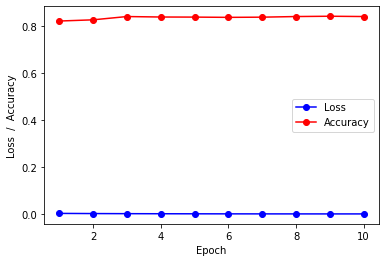

In [19]:
import matplotlib.pyplot as plt
epoch = range(1, 10+1) #epoch 숫자만큼
plt.plot(epoch, avg_loss_history,'-bo', label='Loss')
plt.plot(epoch, test_history, '-ro', label='Accuracy')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss  /  Accuracy');
print(f'Best_Accuracy : {round(0.8406610378912686, 2)}')

- epoch 별 acc 

In [1]:
test_history=[0.8202996293245469,
 0.825447899505766,
 0.8393739703459637,
 0.8373918863261944,
 0.837005766062603,
 0.8359246293245469,
 0.836748352553542,
 0.8393997116968699,
 0.8406610378912686,
 0.8394254530477759]

Best_Accuracy : 0.84


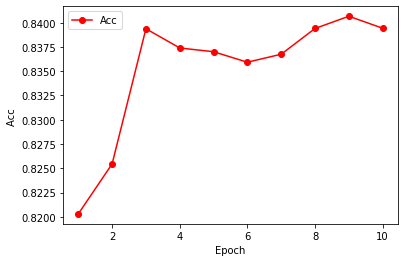

In [7]:
import matplotlib.pyplot as plt 
epoch = range(1, 10+1) 
plt.plot(epoch, test_history,'-ro', label='Acc')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Acc ');
print(f'Best_Accuracy : {round(0.8406610378912686, 2)}')

- epoch 별 loss

In [16]:
avg_loss_history=[0.0024614579898794902,
 0.0017657759939272378,
 0.0013223380280524184,
 0.000979967962220772,
 0.0007267140850578386,
 0.0005231302056807218,
 0.00039936182617219455,
 0.00031692028852160444,
 0.0002794341196200436,
 0.00026155919979144003]

Best_Accuracy : 0.84


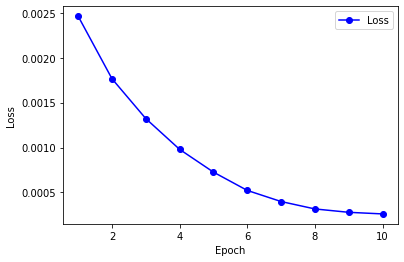

In [17]:
import matplotlib.pyplot as plt 
epoch = range(1, 10+1) 
plt.plot(epoch, avg_loss_history,'-bo', label='Loss')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss ');
print(f'Best_Accuracy : {round(0.8406610378912686, 2)}')

- f1_score, accuracy , confusion matrix(y_test, y_pred)

In [ ]:
test_frame=pd.DataFrame(test,columns=['doc','label'])

test_frame.groupby(['label'])['label'].count()

label
0    19398
1    19392
Name: label, dtype: int64

In [ ]:
#f1 score 용 pred 예측진행
# best_acc_model
# 문장별 예측함수(1,0)

def predict(sentence):
  data = [sentence, '0']
  dataset_another = [data]
  logits = 0 #예측값 임의지정 
  another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False) #bert 데이터형식으로 만들기
  test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
  
  model.eval()

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)

      valid_length= valid_length
      label = label.long().to(device)

      out = model(token_ids, valid_length, segment_ids) #예측 결과 리스트

      for i in out:
        logits = i
        logits = logits.detach().cpu().numpy()
        logits = np.argmax(logits) #1,0 분류값

  return logits

In [ ]:
# train_test_split 진행했던 기존 라벨링된 test 데이터로 predict 진행, by best_acc_model

# batch_size 수정 코드
batch_size = 64 #128로 할 경우 gpu 터질수 있음
max_len=128 #학습모델과 맞춰주기



#test_data['label']=5 #임의지정해도 영향없음, bert 함수에 해당하는 데이터 형식 맞춰주기위함

test_data3 = test_frame.copy()
test_data3 = test_data3.reset_index(drop=True )
test_data3['pred'] = ''



best_acc_model.eval() #model=훈련한 best_acc_model (acc : 0.8406610378912686)에 대한 평가모드




unseen_values = test_data3[['doc', 'label']].values


test_set = BERTDataset(unseen_values, 0, 1, tok, max_len, True, False)
test_input = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=5)
for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_input)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  out = model(token_ids, valid_length, segment_ids)
  for outn in range(len(out)) :
    pred = int(out[outn].argmax().cpu().numpy())
    idx = batch_size * batch_id + outn
    test_data3.iloc[idx, -1] = pred

 # 5000개 단위로 예측값 및 진행도 출력
    if idx % 5000 == 0 :
      print(idx, pred)


test_data3.head(20)


1it [00:00,  4.99it/s]

0 1


79it [00:12,  6.39it/s]

5000 0


158it [00:24,  6.43it/s]

10000 1


236it [00:36,  6.55it/s]

15000 1


314it [00:48,  6.57it/s]

20000 0


392it [01:00,  6.64it/s]

25000 1


470it [01:12,  6.74it/s]

30000 1


548it [01:23,  6.75it/s]

35000 1


607it [01:32,  6.57it/s]


'\n인덱스 5000개 단위로 예측값이 나오며 진행도를 보여줍니다.\n모델 예측값은 pred 컬럼으로 나옵니다.\n'

In [ ]:
test_data3

,doc,label,pred
0,가스공사 지역공사등에 납품하는 안정적인 기업이다 남북 통일되면 성장이 기대되는 회사,0,1
1,편하게 일하는 부서가 많고 제대로 일하는 사람이 정당한 대우를 받고 있는가에 대한 ...,0,1
2,정규직은 중견이라 썩 괜찮은 조건이지만 계약직은 글쎄,0,1
3,머리쓰는 추격전이었다면 더 잼있었을텐데.,0,1
4,다른걸 다 떠나서 제목이 새크레이드 가 뭐냐.네이버 영어사전만 찾아봐도 세이크리드...,0,0
...,...,...,...
38785,그럴듯하지만 글쎄요뒤통수맞은 직원들은 마음이 아픕니다,0,0
38786,남경 학살 주장은 중국의 날조된 거짓으로 드러났어요.,0,0
38787,하. 내가 예고편 보고 끄긴 처음이다. 정말 예고편이라도 재밌으면 보기라도 할텐데....,0,0
38788,그래도 10점을 주고 싶다,1,1


In [ ]:
test_data3.to_excel('/content/drive/MyDrive/modeling_yy/kobert_trainDT_predict_ver2.xlsx')

In [ ]:
y_test=test_frame['label']
y_pred=list(test_data3['pred'])

In [ ]:
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import f1_score,confusion_matrix
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.84      0.83      0.84     19398
           1       0.84      0.84      0.84     19392

    accuracy                           0.84     38790
   macro avg       0.84      0.84      0.84     38790
weighted avg       0.84      0.84      0.84     38790



In [ ]:
print(confusion_matrix(y_test, y_pred)) # 1,0의 비율이 비슷함


[[16183  3215]
 [ 3023 16369]]


In [ ]:
accuracy_score(y_test,y_pred)

0.8391853570507863

In [ ]:
f1_score(y_test,y_pred)

0.8399527914614122

## 12. 모델저장


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

- 경로설정 오류시 PATH = '/content/drive/MyDrive/modeling_yy/'

In [ ]:
#경로설정 오류시 PATH = '/content/drive/MyDrive/modeling_yy/'
PATH = '/content/drive/MyDrive/modeling_yy/'
torch.save(best_acc_model, PATH + 'bert_model_ver2.pt')  # 전체 모델 저장
torch.save(best_acc_model.state_dict(), PATH + 'bert_model_state_dict_ver2.pt')  # 모델 객체의 state_dict 저장
torch.save({'model': best_acc_model.state_dict(), 'optimizer': optimizer.state_dict()}, PATH + 'bert_all_ver2.tar')  

In [ ]:
#PATH = '/content/drive/MyDrive/modeling_yy/'
#torch.save(model.state_dict(), PATH + 'sentiment_kobert_ver1.pt')

## 13. 전이학습 및 예측 

In [ ]:
#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

In [ ]:
#cuda 에러 해결 참고 : https://stackoverflow.com/questions/69968477/runtimeerror-cuda-error-no-kernel-image-is-available-for-execution-on-the-devi
#버전 에러발생으로 재설치
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

#kobert
from kobert.utils import get_tokenizer
#from kobert.pytorch_kobert import get_kobert_model
from kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

## CPU 사용시
#device = torch.device("cpu")

#GPU 사용
device = torch.device("cuda:0")

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()


/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
#kobert
from kobert.utils import get_tokenizer
tokenizer = get_tokenizer()

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()
#lower=False 한글이니까 상관 없을듯..?
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [ ]:
class BERTClassifier(nn.Module):
  def __init__(self, bert, hidden_size=768, num_classes=2, dr_rate=None, params=None):
    super(BERTClassifier, self).__init__()
    self.bert = bert
    self.dr_rate = dr_rate

    self.classifier = nn.Linear(hidden_size , num_classes)
    if dr_rate:
      self.dropout = nn.Dropout(p=dr_rate)

  def gen_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i, v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    return attention_mask.float()

  def forward(self, token_ids, valid_length, segment_ids):
    attention_mask = self.gen_attention_mask(token_ids, valid_length)
    _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
    if self.dr_rate:
        out = self.dropout(pooler)
    else:
        out = pooler
    return self.classifier(out)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#모델변수 코드 추가
import torch
PATH = '/content/drive/MyDrive/modeling_yy/'
model = torch.load(PATH + 'bert_model_ver2.pt')

learning_rate =  5e-5

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

#옵티마이저, 손실함수 지정
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

#model = torch.load(PATH + 'bert_model_ver2.pt')  # 모델 불러오기
model.load_state_dict(torch.load( PATH + 'bert_model_state_dict_ver2.pt'))

checkpoint = torch.load(PATH + 'bert_all_ver2.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

- test (예측을 위해 수집한 데이터) 전처리(리스트화 및 토큰화)

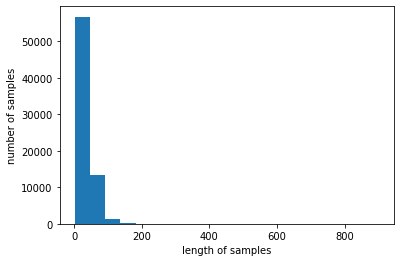

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

test_data=pd.read_excel('/content/drive/MyDrive/modeling_yy/test_data.xlsx')
plt.hist([len(doc) for doc in test_data['doc']], bins = 20)
plt.xlabel('length of samples'), plt.ylabel('number of samples');

* Predict 예측함수 정의

In [ ]:
# 문장별 예측함수(1,0)

def predict(sentence):
  data = [sentence, '0']
  dataset_another = [data]
  logits = 0 #예측값 임의지정 
  another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False) #bert 데이터형식으로 만들기
  test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
  
  model.eval()

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)

      valid_length= valid_length
      label = label.long().to(device)

      out = model(token_ids, valid_length, segment_ids) #예측 결과 리스트

      for i in out:
        logits = i
        logits = logits.detach().cpu().numpy()
        logits = np.argmax(logits) #1,0 분류값

  return logits

In [ ]:
PATH = '/content/drive/MyDrive/modeling_yy/'
model = torch.load(PATH + 'bert_model_ver2.pt')  # 모델 불러오기
#model.load_state_dict(torch.load( PATH + 'bert_model_state_dict.pt'))


In [ ]:
import pandas as pd
test_data=pd.read_excel('/content/drive/MyDrive/modeling_yy/test_data.xlsx')
test_data

,id,year,doc,content,ecnt,scnt,gcnt
0,1,2020,원수가 다니겠다고 하면 도시락 싸 들고 환영할 회사 중소기업의 흔한 사건사고 단점 ...,장점 꼰대 문화가 별로 없고 변화와 발전 추구함 투자를 많이 받고 있기 때문에 사...,0,2,3
1,1,2020,앞으로도 더 성장 할 가능성이 높은 회사,장점 직원들에게 많은 기회를 준다 한가지만 보지 않고 다양한 분야에서 어떻게 인재가...,0,0,2
2,1,2020,블리츠웨이 300 꿈의 장난감 볼트론 피규어로 매출 100억원 기대,피규어 전문제작사 블리츠웨이가 출시 예정인 볼트론이 사전예약 첫 날 자체 예약 최고...,0,0,0
3,1,2020,배용준도 투자한 블리츠웨이 코스닥 예비심사 통과 정밀 피규어 최초 상장 기대,피규어 개발 및 제작 전문 기업 블리츠웨이가 코스닥 상장을 위한 예비 심사를 통과했...,0,0,0
4,1,2020,대신밸런스제9호스팩 블리츠웨이와 합병 승인 12월 코스닥 상장,대신밸런스제9호스팩은 피규어 개발 제작 전문 기업 블리츠웨이 와 합병상장을 위한 ...,0,0,0
...,...,...,...,...,...,...,...
71829,1382,2020,레미콘제조업체로 현상유지만 하고있음앞으로 전망은 낙관적이지 않음,장점 공장은 장점 이 없고 서울본사는 근무할만 함빽있는 사람은 다닐만함 단점 빽없는...,0,0,3
71830,1382,2020,개 법인이 같이 운영되고 있음 그중 개는 죽쑤는중 덕원이랑 모헨즈가 이끌어감 덕원은...,장점 중소기업치고 연봉이 높은편 대신 성과금이 없다 본사에입사하면 워라밸 가능함 공...,0,0,1
71831,1382,2021,차산업 특성상 육체노동의 불가피함 진급욕심가득한 몇몇으로 인해 피해보는 직원 속출,장점 직원들 대부분의 성향이 밝은 쪽이 많음 적응하는 기간이 오래걸리지않고 형동생으...,0,1,1
71832,1382,2021,사람을 가볍게 여기는 회사 임원진들만 잘먹고 잘사는 회사,장점 월급이 밀리지 않고 제 때 들어오는것이 이 회사의 유일한 장점 단점 정해놓은...,0,0,1


In [ ]:
test_data['label']=5
test_data

,id,year,doc,content,ecnt,scnt,gcnt,label
0,1,2020,원수가 다니겠다고 하면 도시락 싸 들고 환영할 회사 중소기업의 흔한 사건사고 단점 ...,장점 꼰대 문화가 별로 없고 변화와 발전 추구함 투자를 많이 받고 있기 때문에 사...,0,2,3,5
1,1,2020,앞으로도 더 성장 할 가능성이 높은 회사,장점 직원들에게 많은 기회를 준다 한가지만 보지 않고 다양한 분야에서 어떻게 인재가...,0,0,2,5
2,1,2020,블리츠웨이 300 꿈의 장난감 볼트론 피규어로 매출 100억원 기대,피규어 전문제작사 블리츠웨이가 출시 예정인 볼트론이 사전예약 첫 날 자체 예약 최고...,0,0,0,5
3,1,2020,배용준도 투자한 블리츠웨이 코스닥 예비심사 통과 정밀 피규어 최초 상장 기대,피규어 개발 및 제작 전문 기업 블리츠웨이가 코스닥 상장을 위한 예비 심사를 통과했...,0,0,0,5
4,1,2020,대신밸런스제9호스팩 블리츠웨이와 합병 승인 12월 코스닥 상장,대신밸런스제9호스팩은 피규어 개발 제작 전문 기업 블리츠웨이 와 합병상장을 위한 ...,0,0,0,5
...,...,...,...,...,...,...,...,...
71829,1382,2020,레미콘제조업체로 현상유지만 하고있음앞으로 전망은 낙관적이지 않음,장점 공장은 장점 이 없고 서울본사는 근무할만 함빽있는 사람은 다닐만함 단점 빽없는...,0,0,3,5
71830,1382,2020,개 법인이 같이 운영되고 있음 그중 개는 죽쑤는중 덕원이랑 모헨즈가 이끌어감 덕원은...,장점 중소기업치고 연봉이 높은편 대신 성과금이 없다 본사에입사하면 워라밸 가능함 공...,0,0,1,5
71831,1382,2021,차산업 특성상 육체노동의 불가피함 진급욕심가득한 몇몇으로 인해 피해보는 직원 속출,장점 직원들 대부분의 성향이 밝은 쪽이 많음 적응하는 기간이 오래걸리지않고 형동생으...,0,1,1,5
71832,1382,2021,사람을 가볍게 여기는 회사 임원진들만 잘먹고 잘사는 회사,장점 월급이 밀리지 않고 제 때 들어오는것이 이 회사의 유일한 장점 단점 정해놓은...,0,0,1,5


In [ ]:
# batch_size 수정 코드

batch_size = 64 #128이상으로 하면 gpu 터질수 있음
max_len=128 #학습모델과 맞춰주기


test_data['label']=5 #임의지정해도 영향없음, bert 함수에 해당하는 데이터 형식 맞춰주기위함

test_data3 = test_data.copy()
test_data3 = test_data3.reset_index(drop=True )
test_data3['pred'] = ''


model.eval() #model=훈련하고 저장한 best_acc_model (acc : 0.8406610378912686)에 대한 평가모드


unseen_values = test_data3[['doc', 'label']].values


test_set = BERTDataset(unseen_values, 0, 1, tok, max_len, True, False)
test_input = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=5)
for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_input)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length= valid_length
  out = model(token_ids, valid_length, segment_ids)
  for outn in range(len(out)) :
    pred = int(out[outn].argmax().cpu().numpy())
    idx = batch_size * batch_id + outn
    test_data3.iloc[idx, -1] = pred

    # 5000개 단위로 예측값 및 진행도 출력
    if idx % 5000 == 0 :
      print(idx, pred)


test_data3.head(20)


1it [00:00,  4.58it/s]

0 0


79it [00:14,  5.46it/s]

5000 0


157it [00:28,  5.47it/s]

10000 1


235it [00:43,  5.46it/s]

15000 0


313it [00:57,  5.52it/s]

20000 1


391it [01:11,  5.55it/s]

25000 0


470it [01:25,  5.58it/s]

30000 0


548it [01:39,  5.56it/s]

35000 1


626it [01:53,  5.67it/s]

40000 0


704it [02:06,  5.70it/s]

45000 0


782it [02:20,  5.76it/s]

50000 1


860it [02:33,  5.79it/s]

55000 1


938it [02:47,  5.79it/s]

60000 1


1017it [03:00,  5.85it/s]

65000 1


1095it [03:14,  5.90it/s]

70000 0


1123it [03:18,  5.65it/s]


'\n인덱스 5000개 단위로 예측값이 나오며 진행도를 보여줍니다.\n모델 예측값은 pred 컬럼으로 나옵니다.\n'

In [ ]:
test_data3

,id,year,doc,content,ecnt,scnt,gcnt,label,pred
0,1,2020,원수가 다니겠다고 하면 도시락 싸 들고 환영할 회사 중소기업의 흔한 사건사고 단점 ...,장점 꼰대 문화가 별로 없고 변화와 발전 추구함 투자를 많이 받고 있기 때문에 사...,0,2,3,5,0
1,1,2020,앞으로도 더 성장 할 가능성이 높은 회사,장점 직원들에게 많은 기회를 준다 한가지만 보지 않고 다양한 분야에서 어떻게 인재가...,0,0,2,5,1
2,1,2020,블리츠웨이 300 꿈의 장난감 볼트론 피규어로 매출 100억원 기대,피규어 전문제작사 블리츠웨이가 출시 예정인 볼트론이 사전예약 첫 날 자체 예약 최고...,0,0,0,5,1
3,1,2020,배용준도 투자한 블리츠웨이 코스닥 예비심사 통과 정밀 피규어 최초 상장 기대,피규어 개발 및 제작 전문 기업 블리츠웨이가 코스닥 상장을 위한 예비 심사를 통과했...,0,0,0,5,1
4,1,2020,대신밸런스제9호스팩 블리츠웨이와 합병 승인 12월 코스닥 상장,대신밸런스제9호스팩은 피규어 개발 제작 전문 기업 블리츠웨이 와 합병상장을 위한 ...,0,0,0,5,1
...,...,...,...,...,...,...,...,...,...
71829,1382,2020,레미콘제조업체로 현상유지만 하고있음앞으로 전망은 낙관적이지 않음,장점 공장은 장점 이 없고 서울본사는 근무할만 함빽있는 사람은 다닐만함 단점 빽없는...,0,0,3,5,0
71830,1382,2020,개 법인이 같이 운영되고 있음 그중 개는 죽쑤는중 덕원이랑 모헨즈가 이끌어감 덕원은...,장점 중소기업치고 연봉이 높은편 대신 성과금이 없다 본사에입사하면 워라밸 가능함 공...,0,0,1,5,1
71831,1382,2021,차산업 특성상 육체노동의 불가피함 진급욕심가득한 몇몇으로 인해 피해보는 직원 속출,장점 직원들 대부분의 성향이 밝은 쪽이 많음 적응하는 기간이 오래걸리지않고 형동생으...,0,1,1,5,0
71832,1382,2021,사람을 가볍게 여기는 회사 임원진들만 잘먹고 잘사는 회사,장점 월급이 밀리지 않고 제 때 들어오는것이 이 회사의 유일한 장점 단점 정해놓은...,0,0,1,5,0


In [ ]:
test_data3['pred'].value_counts(normalize=True)

1    0.555308
0    0.444692
Name: pred, dtype: float64

In [ ]:
test_data3.to_excel('/content/drive/MyDrive/modeling_yy/kobert_predict_ver2.xlsx')

## 14. 성능 평가 : F1 Score
F1 SCORE는 precision과 recall을 가중평균하여 계산.
- recall : (모델이 TRUE라고 판정한 것의 숫자)/(전체 TRUE의 숫자)
- precision : (진짜 TRUE) / (모델이 TRUE라고 판정한 것의 숫자)

In [ ]:
# 훈련 모델의 예측 성능을 F1 SCORE로 체크하기 위한 작업

def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []
    
    for i in tqdm(range(len(data_df))):

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        segments.append(segment)
        masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

In [ ]:
from sklearn.metrics import classification_report

y_true = test['label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))